Goal
===
1. Dowanload [Walmark dat from Kaggle](https://www.kaggle.com/datasets/yasserh/walmart-dataset)
2. work on Google drive with data
3. Learning three kind of Tree-based Model, xgboost, lightboost, catboost


- [Article](https://dataman-ai.medium.com/tree-based-xgb-lightgbm-and-catboost-models-for-multi-period-time-series-probabilistic-6b12d1500779)
- [Github Src](https://github.com/dataman-git/codes_for_articles/tree/master)

Claude.ai: Use it to compare their features:
---

| Feature | XGBoost | LightGBM | CatBoost |
| --- | --- | --- | --- |
| Speed | &lt; LightGBM | &gt; XGBoost | ≃ XGBoost |
| Memory Usage | High | Low | Moderate |
| Handling Categorical Variables | Requires One-Hot Encoding | Native Support | Native Support |
| Handling Missing Values | No native support (needs preprocessing) | Native Support (can handle NaN) | Native Support (can handle NaN) |
| GPU Support | Yes | Yes | Yes |
| Tree Growth Strategy | Depth-wise | Leaf-wise | Combination (Leaf-wise and Depth-wise) |
| Split Finding Algorithm | Exact and Approximate | Exact | Exact and Approximate |
| Regularization | L1 and L2 | L1, L2, and Max Depth | L2 |
| Feature Importance Calculation | Yes | Yes | Yes |
| Advanced Features | No | Yes | Yes |


| 功能 | XGBoost | LightGBM | CatBoost |
| --- | --- | --- | --- |
| 速度 | 較 LightGBM 慢 | 較 XGBoost 快 | 與 XGBoost 相當 |
| 記憶體使用 | 高 | 低 | 適中 |
| 處理分類變數 | 需要一次性編碼 | 原生支援 | 原生支援 |
| 處理遺失值 | 沒有原生支援 (需要預處理) | 原生支援 (可處理 NaN) | 原生支援 (可處理 NaN) |
| GPU 支援 | 有 | 有 | 有 |
| 樹生長策略 | 深度優先 | 葉子優先 | 組合 (葉子優先和深度優先) |
| 分割查找算法 | 精確和近似 | 精確 | 精確和近似 |
| 正則化 | L1 和 L2 | L1、L2 和最大深度 | L2 |
| 特徵重要性計算 | 有 | 有 | 有 |
| 進階功能 | 無 | 有 | 有 |

Time-Series Prediction
---
[  Inputs  ] ➡︎ [  Output(s) ]

1. Quantile prediction (interval prediction not unique point prediction):
``` 
        Past       Future

   |             |        /  º  90 %
   |             |        .. º  50 %
   |             |  .-.   -- x  5 % 
   |             |../
   |-------------|----------|--
   |                        t
```

1. Multiple Periods, interval prediction (n outputs)  not point prediction (only one value)
```
   x[t-k], ... , x[t-1], x[t] ➜  x[t+1]
         x[t-k+1], ... , x[t] +  ➚      ⤷ x[t+2]
                  x[t-k+2], ..., x[t+1] +  ➚      ⤷ x[t+3]
                            ...
```

**Not**,  use same `model` to predict the next.

2. Or one model not several ones to predict independently:
```
   x[t-p],..., x[t-1], x[t]   ➜   x[t+1]
                              ➜          x[t+2]
                              ➜                  x[t+3]
                                      ...
```
Packages `darts` does!

**Note**, unlike above, only one model created, `diffenent` training for prediction for each values.

In [232]:
!pip install -q darts

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from darts import TimeSeries
from darts.metrics.metrics import mae, mape
from darts.models import XGBModel,LightGBMModel, CatBoostModel
from darts.explainability.shap_explainer import ShapExplainer

from prophet import Prophet

import dtreeviz

/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c1017RegisterOperatorsD1Ev)
  Referenced from: '/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/chu-chinghuang/opt/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-04-25 07:13:27.172555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [2]:
# make the output clean
import warnings
warnings.filterwarnings('ignore')

If runs on Google drive, we has to download the data anf upload it:
```
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/2023/2023-2-Python-AI/data'
```

In [3]:
# load data
path='data'
#path='/content/gdrive/MyDrive/2023/2023-2-Python-AI/data'
data = pd.read_csv(path + '/Walmart.csv', delimiter=",")

In [9]:
data.tail()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
6430     45  28-09-2012     713173.95             0        64.88       3.997   
6431     45  05-10-2012     733455.07             0        64.89       3.985   
6432     45  12-10-2012     734464.36             0        54.47       4.000   
6433     45  19-10-2012     718125.53             0        56.47       3.969   
6434     45  26-10-2012     760281.43             0        58.85       3.882   

             CPI  Unemployment  
6430  192.013558         8.684  
6431  192.170412         8.667  
6432  192.327265         8.667  
6433  192.330854         8.667  
6434  192.308899         8.667

In [4]:
# index by data, renamed as 'ds'
data['ds'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.index = data['ds']
data = data.drop('Date', axis=1)
data.head()

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
ds                                                                       
2010-02-05      1    1643690.90             0        42.31       2.572   
2010-02-12      1    1641957.44             1        38.51       2.548   
2010-02-19      1    1611968.17             0        39.93       2.514   
2010-02-26      1    1409727.59             0        46.63       2.561   
2010-03-05      1    1554806.68             0        46.50       2.625   

                   CPI  Unemployment         ds  
ds                                               
2010-02-05  211.096358         8.106 2010-02-05  
2010-02-12  211.242170         8.106 2010-02-12  
2010-02-19  211.289143         8.106 2010-02-19  
2010-02-26  211.319643         8.106 2010-02-26  
2010-03-05  211.350143         8.106 2010-03-05

6435

In [20]:
# no null value
data.isnull().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
ds              0
dtype: int64

Data
---
1. from [Kaggle](https://www.kaggle.com/datasets/yasserh/walmart-dataset
2. Features:

| Feature | Entity |
| --- | --- |
| Date (日期) | the week of sales (周銷售量) |
| Store (商店) | the store number (商店編號) |
| Weekly_Sales (每週銷售量) | sales for a store (每週銷售量) |
| Holiday_Flag (假日標誌) | whether the week is a special holiday week, 1: Yes, 0: No (是否為假期週, 1: Yes, 0: No) |
| Temperature (溫度) | Temperature on the day of sale (銷售期間溫度) |
| Fuel_Price (燃料價格) | Cost of fuel in the region (燃料價格) |
| CPI (`C`onsumer `P`rice `I`ndex 消費者價格指數)||
| Unemployment (失業率)||

In [5]:
# $ data.dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Weekly_Sales  6435 non-null   float64       
 2   Holiday_Flag  6435 non-null   int64         
 3   Temperature   6435 non-null   float64       
 4   Fuel_Price    6435 non-null   float64       
 5   CPI           6435 non-null   float64       
 6   Unemployment  6435 non-null   float64       
 7   ds            6435 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 452.5 KB


In [6]:
# grouped by store and keep ds as index
darts_group_df = TimeSeries.from_group_dataframe(data, group_cols='Store', time_col='ds')
print("The number of groups/stores is:", len(darts_group_df))
print("The number of time period is: ", len(darts_group_df[0]))

The number of groups/stores is: 45
The number of time period is:  143


Meta Prophet
---
a Simple but powerful data for Time Series data:
Demo
---   
```python
# without parameter fine-tuning
df=pd.read_csv("data.csv")
df_p=df[['ds','y']].copy()

model = Prophet()
model.fit(df_p)

future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

In [22]:
df=data.iloc[:143,:].copy()
df_p=pd.DataFrame()
df_p['y']=df['Weekly_Sales']
df_p['ds']=list(df.index)

In [23]:
model = Prophet()
model.fit(df_p)

07:24:47 - cmdstanpy - INFO - Chain [1] start processing
07:24:47 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future = model.make_future_dataframe(periods=10, freq='W')
forecast = model.predict(future)

In [27]:
print(forecast[['ds', 'yhat']].tail(10))

            ds          yhat
143 2012-10-28  1.532358e+06
144 2012-11-04  1.598368e+06
145 2012-11-11  1.688376e+06
146 2012-11-18  1.745378e+06
147 2012-11-25  1.766525e+06
148 2012-12-02  1.809151e+06
149 2012-12-09  1.912231e+06
150 2012-12-16  2.022694e+06
151 2012-12-23  2.024212e+06
152 2012-12-30  1.854370e+06


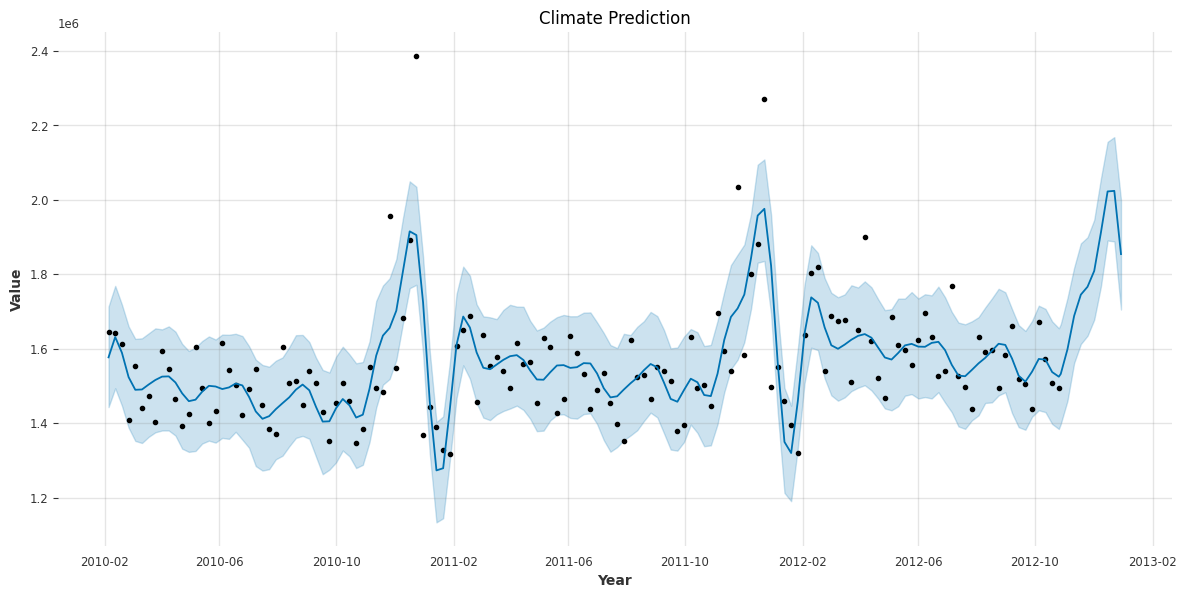

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
model.plot(forecast, ax=ax)
ax.set_title('Climate Prediction')
ax.set_xlabel('Year')
ax.set_ylabel('Value')
plt.show()

Conclusion
---
After data grouped by store, there are 45 different stores whish owns 145 data (by week) respectively.

In [63]:
def df_groupby(df,target):
    df_group=df.groupby(target)
    return df_group
df_test= df_groupby(data,'Store')


In [79]:
# how many grouped data
## df_test.size()
# list the groups with index-list, in which it owns data
## df_test.groups
# get the specified grouped data
## df_test.get_group(1)
del df_test

In [7]:
darts_group_df[0].components

Index(['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object', name='component')

Model Training
---
typically, split data into two parts, one for model training and other for test to get much accuracy. 

In [12]:
# Split by train/test: 0.9/0.1
store1 = darts_group_df[0]
train = store1[:130]
test = store1[130:]
len(train), len(test) # (130, 13)

(130, 13)

In [86]:
#data.iloc[0,:]

In [85]:
# darts_group_df[0][0]

In [13]:
# the output, target, i.e. 'Weekly_Sales'
# the target could afftected bt the past 'Fuel_Price' and 'CPI'
# also the future holiday (wherever or not) could affect the customer's comsumption.
# this factor almost definitely known but not unknown.

target = train['Weekly_Sales']
past_cov = train[['Fuel_Price','CPI']]
future_cov = store1['Holiday_Flag'][:143]

There are two types of covariates in time series : `past covariates` and `future covariates`.
- past covariates: observed data with historical features, here are `Fuel_Price`, `CPI`.
- future covariates: certainly, the sales will be affected by the future `Holiday` or future Climate forecast. 

In [14]:
darts_group_df = TimeSeries.from_group_dataframe(data, group_cols='Store', time_col='ds')
print("The number of groups/stores is:", len(darts_group_df))
print("The number of time period is: ", len(darts_group_df[0]))

The number of groups/stores is: 45
The number of time period is:  143


In [15]:
n = 12
model_lgb = LightGBMModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model_lgb.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model_lgb.predict(n)


In [18]:
features=['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI','Unemployment']
target= ['Weekly_Sales']

In [31]:
pred.values()

array([[1648229.14360717],
       [1647585.15388686],
       [1569763.01141598],
       [1627100.35048412],
       [1679217.5866184 ],
       [1711997.88579476],
       [1678208.72099501],
       [1731293.24264894],
       [1554316.24884006],
       [1692049.51861498],
       [1546896.79482908],
       [1510526.78395763]])

In [40]:
shap_explain = ShapExplainer(model_lgb)
results = shap_explain.explain()

In [87]:
import shap

In [103]:
#shap_explain.summary_plot(plot_type="bar")

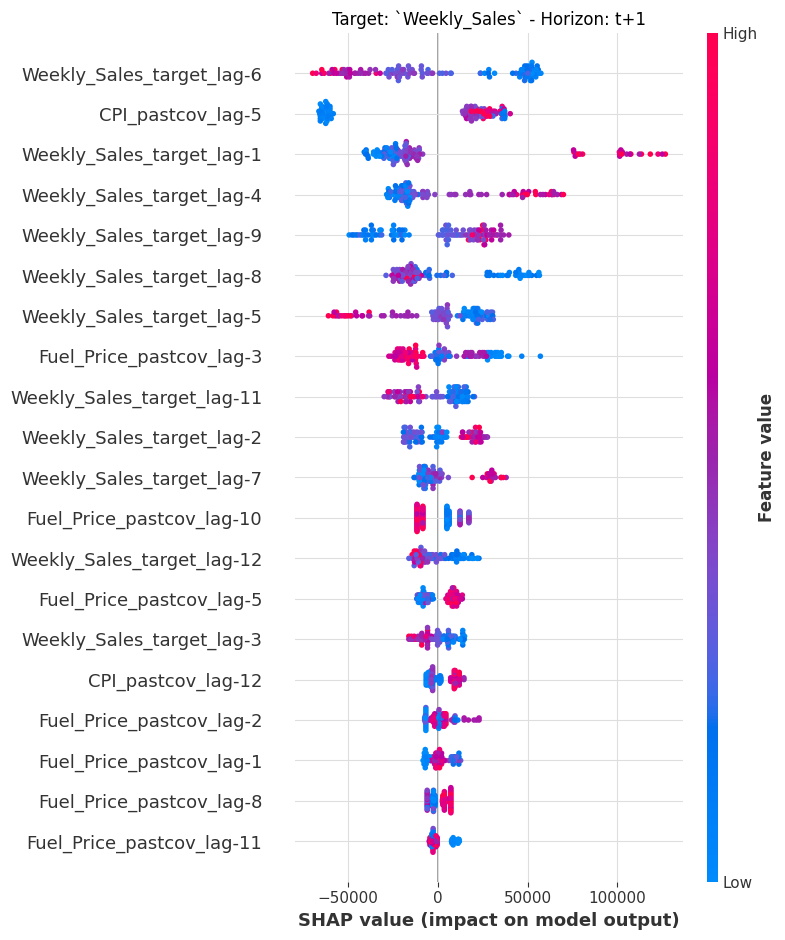

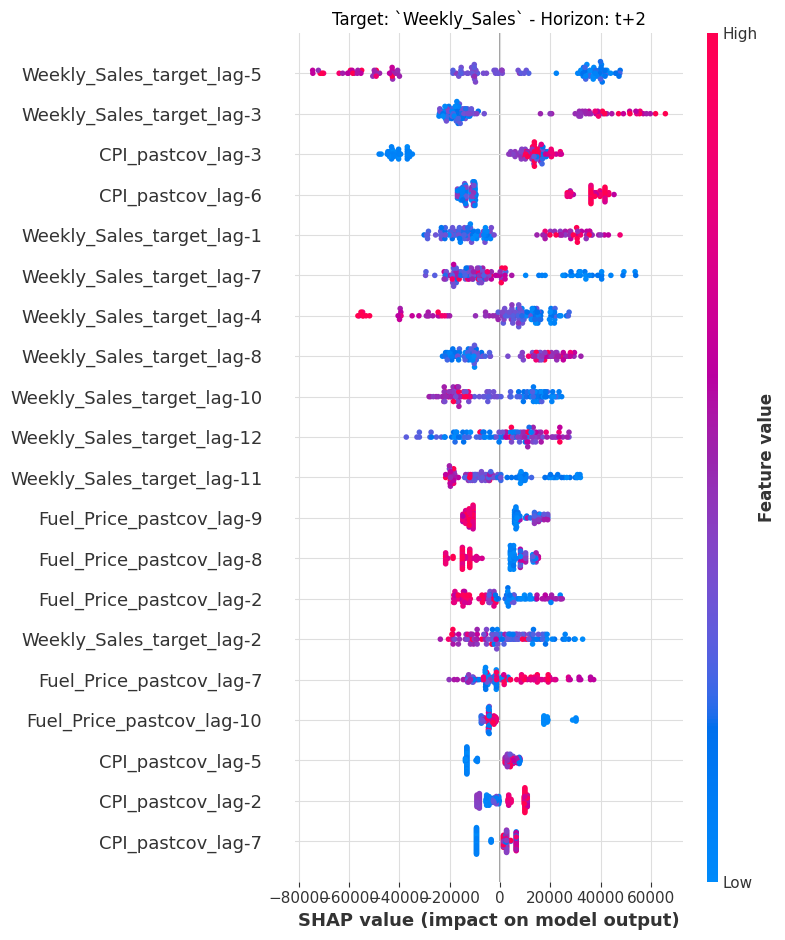

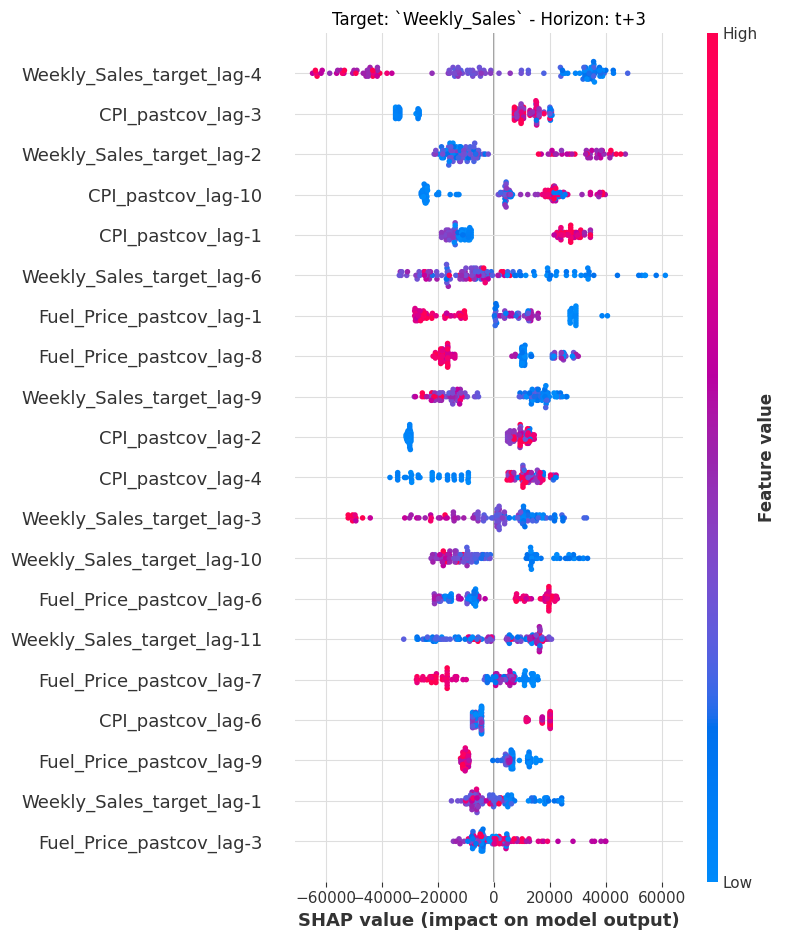

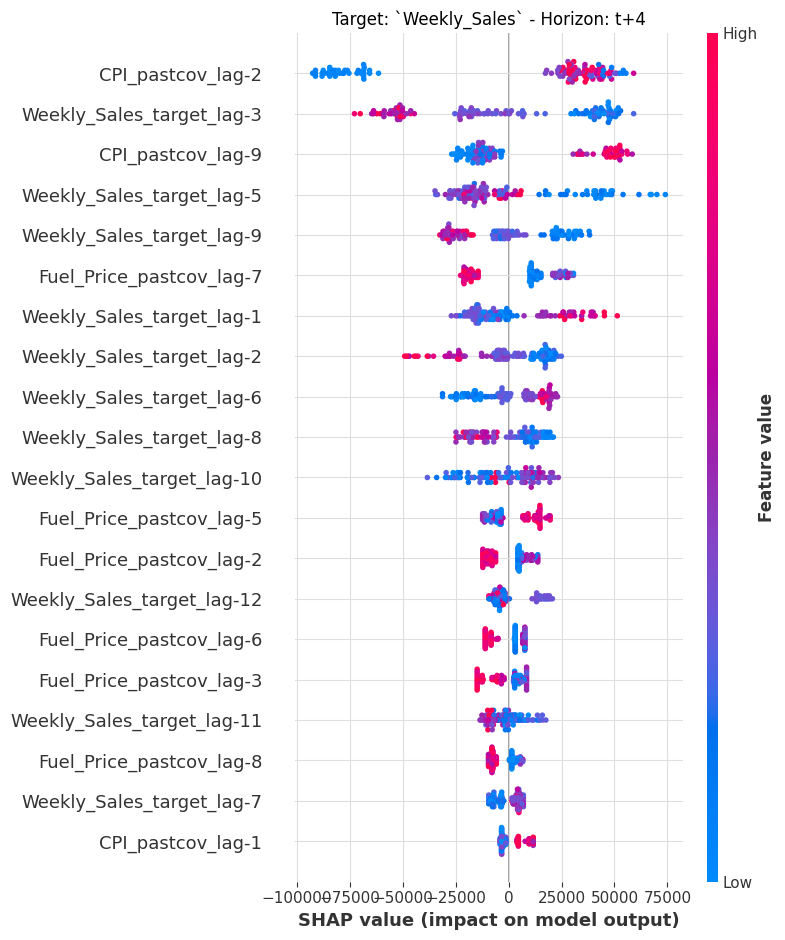

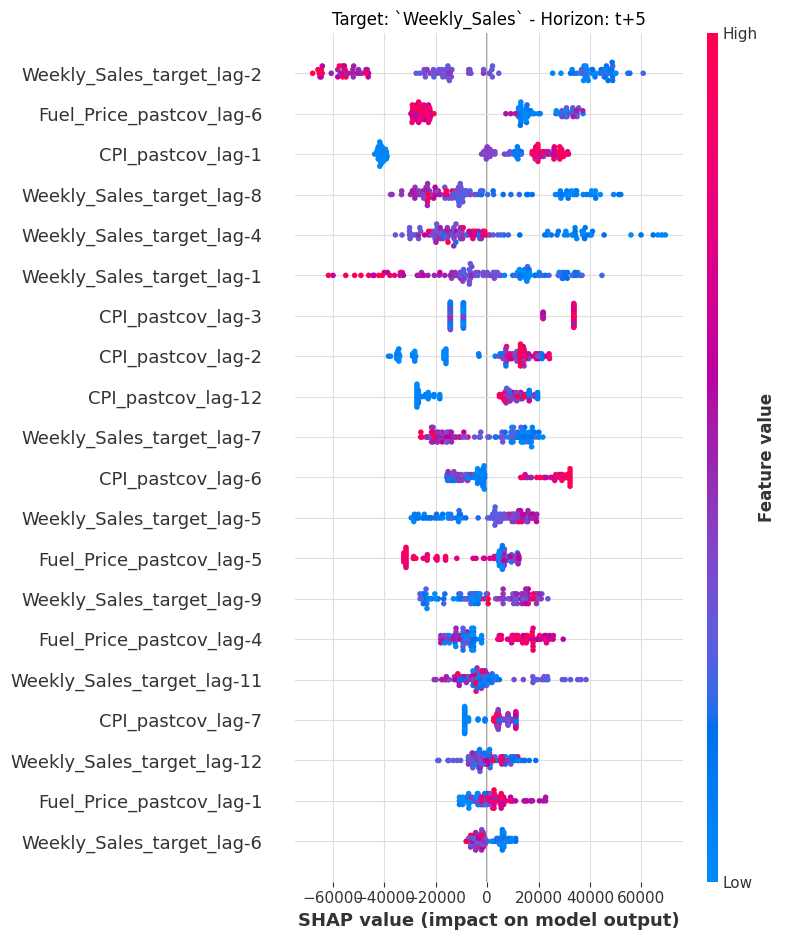

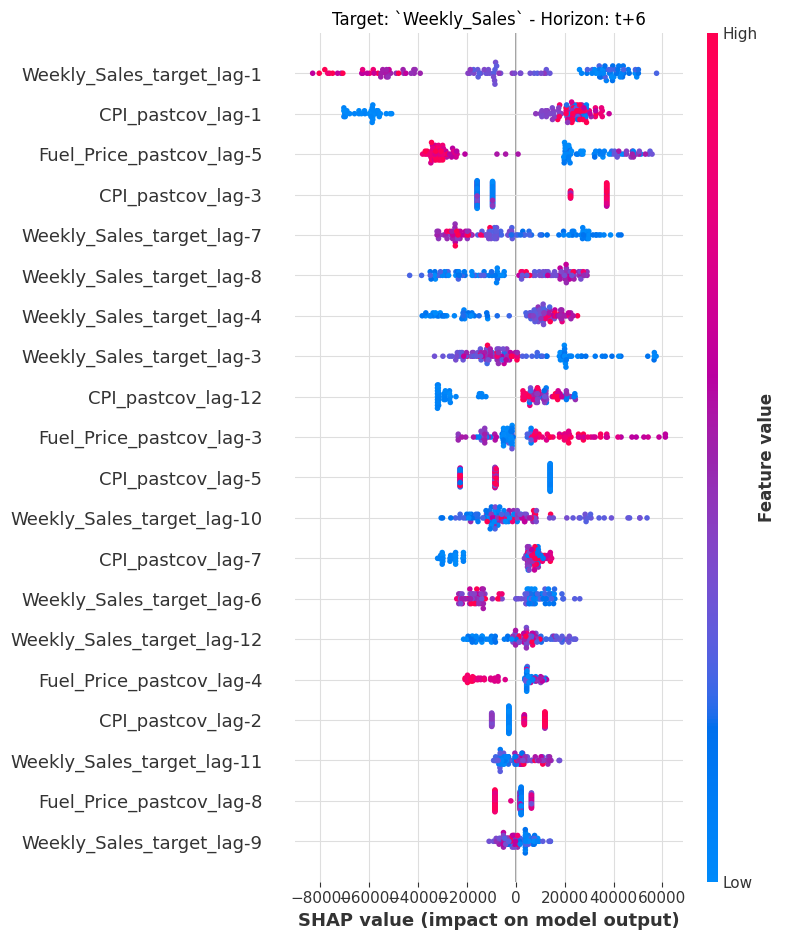

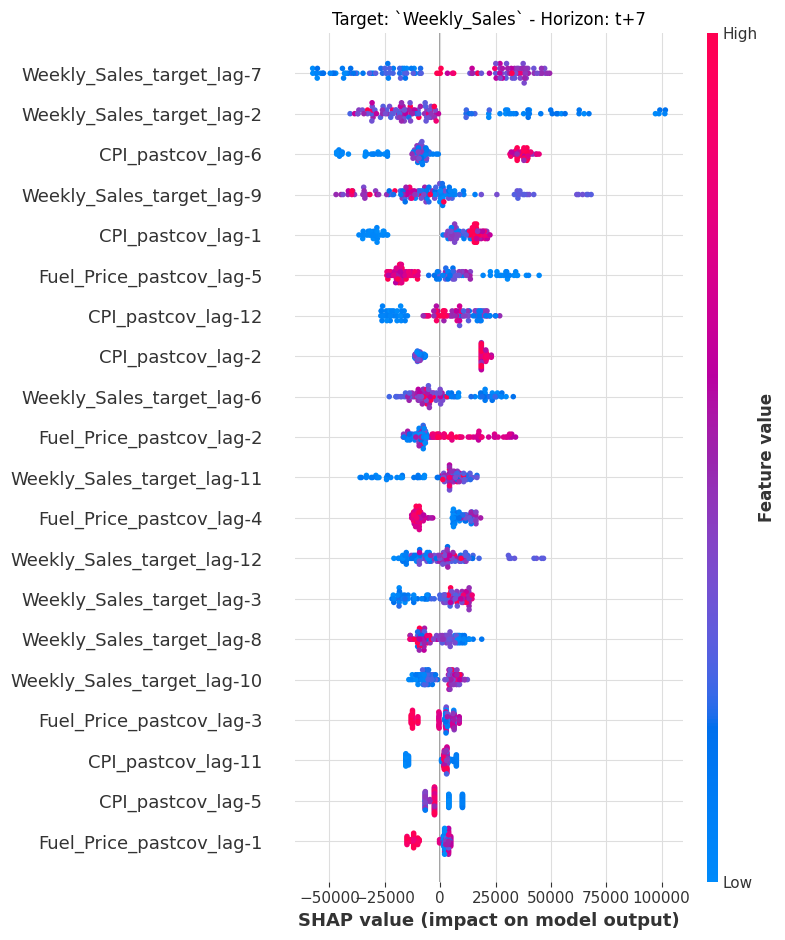

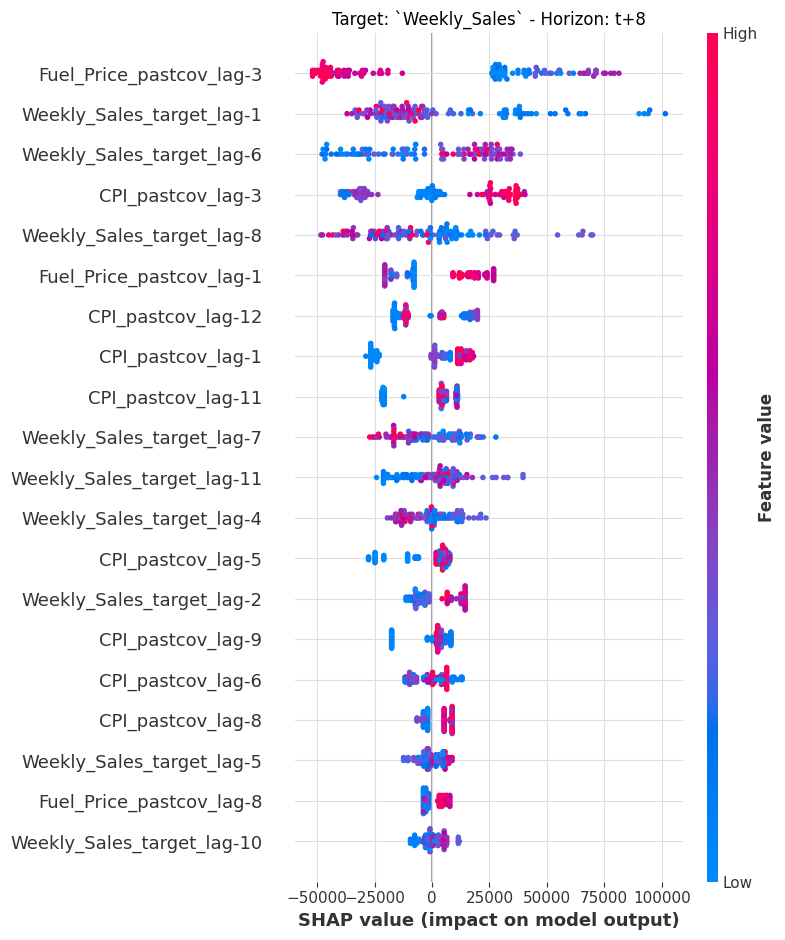

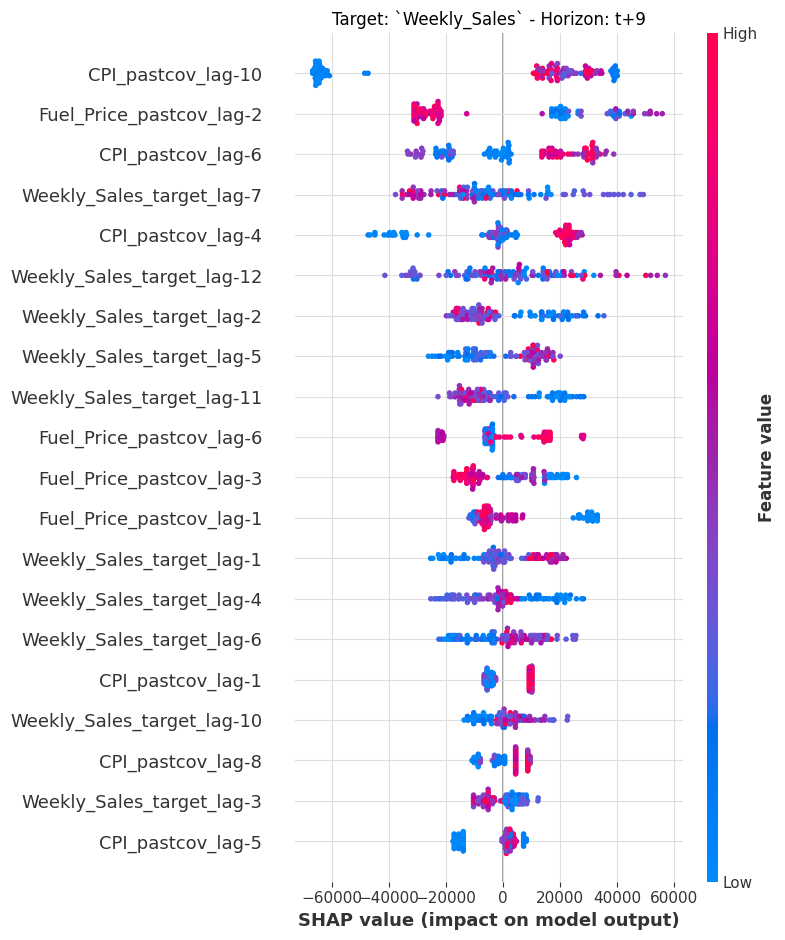

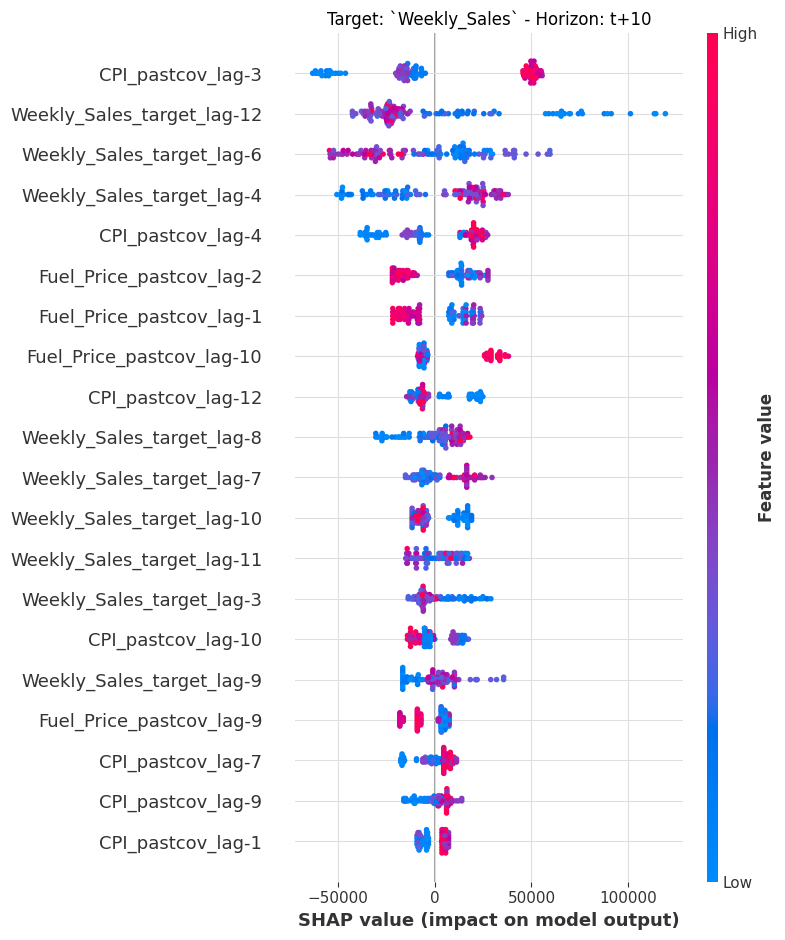

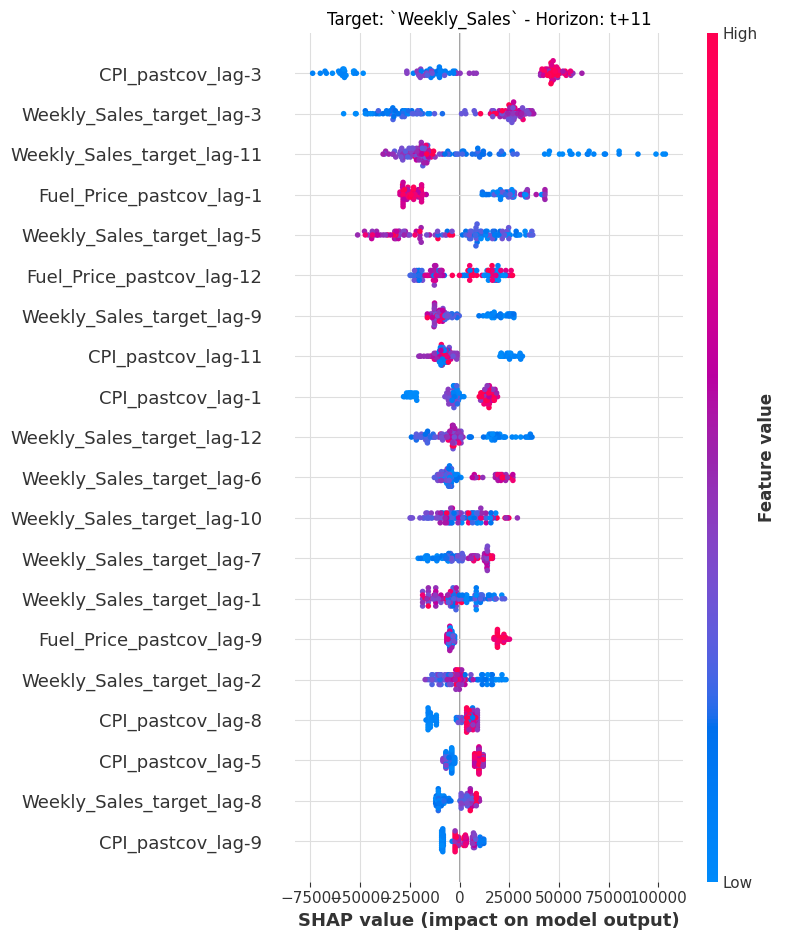

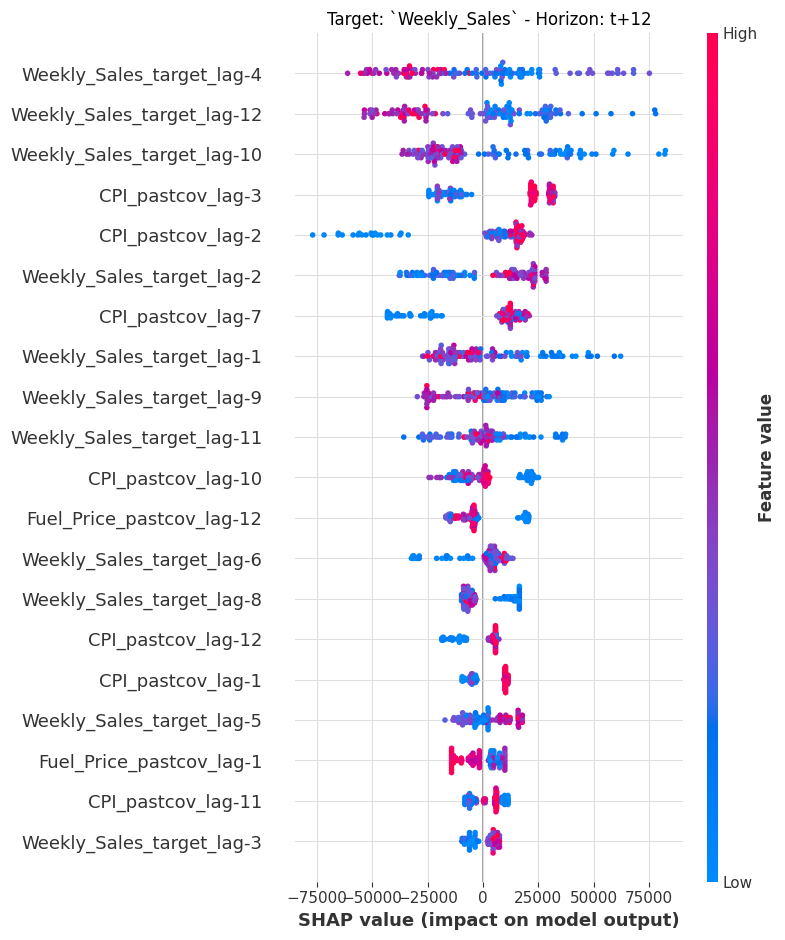

{1: {'Weekly_Sales': .values =
  array([[-10811.31108248, -21994.41153775,  -1319.56997242, ...,
               0.        ,      0.        ,      0.        ],
         [ -3777.80971994, -20909.83714638,   3076.95200875, ...,
               0.        ,      0.        ,      0.        ],
         [ -7475.49750293,  14662.31194154,     73.32121183, ...,
               0.        ,      0.        ,      0.        ],
         ...,
         [  -645.77270994, -17160.34842069,  -4543.26379536, ...,
               0.        ,      0.        ,      0.        ],
         [ -9341.65041294, -17388.04517561,  -4643.58437431, ...,
               0.        ,      0.        ,      0.        ],
         [ -9709.94567599, -10135.24275935,  -4643.58437431, ...,
               0.        ,      0.        ,      0.        ]])
  
  .base_values =
  array([1556588.83174863, 1556588.83174863, 1556588.83174863,
         1556588.83174863, 1556588.83174863, 1556588.83174863,
         1556588.83174863, 1556588.83174

In [104]:
shap_explain.summary_plot()

In [47]:
shap_explain.force_plot_from_ts()

In [56]:
results.

In [52]:
def plotit():
  target.plot(label = 'train')
  pred.plot(label = 'prediction')
  test['Weekly_Sales'][:n].plot(label = 'actual')

  print("Mean Absolute Error:", mae(test['Weekly_Sales'][:n], pred))
  print("Mean Absolute Percentage Error", mape(test['Weekly_Sales'][:n], pred))


AI LLM, Coding Help
---
Here will show how to create Python function by [Claude 3](claude.ai):
1. copy above code of modeling above,
2. ask LLM to convert the code pasted below.
3. modify the result to suit the need; 
4. Finally, ask it to simply the work, just the following shown.

Interested person can look the news about `Devin AI` , the recent AI engineer.

In [34]:
# function 
def create_tree_based_model(model_type, n, quantiles):
    chunk_length = n
    model_map = {
        'xgboost': XGBModel,
        'lightgbm': LightGBMModel,
        'catboost': CatBoostModel
    }
    if model_type not in model_map:
        raise ValueError("Invalid model type. Please choose 'xgboost', 'lightgbm', or 'catboost'.")
    
    model_ = model_map[model_type](
            random_state=123,
            lags=n,
            lags_past_covariates=n,
            lags_future_covariates=[i for i in range(n)],
            output_chunk_length=chunk_length,
            likelihood='quantile',
            quantiles=quantiles
        )
    
    return model_

In [38]:
model_lgb=create_tree_based_model('lightgbm', 12, [0.01, 0.05, 0.50, 0.95, 0.99])
model_lgb.fit(target, past_covariates=past_cov, future_covariates=future_cov)

LightGBMModel(lags=12, lags_past_covariates=12, lags_future_covariates=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], output_chunk_length=12, output_chunk_shift=0, add_encoders=None, likelihood=quantile, quantiles=[0.01, 0.05, 0.5, 0.95, 0.99], random_state=123, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [39]:
pred=model_lgb.predict(n)
pred.values()

array([[1578825.01353882],
       [1624275.4445751 ],
       [1570306.37951426],
       [1583454.70519032],
       [1675830.01232001],
       [1676351.18747874],
       [1663542.50067091],
       [1645359.17726312],
       [1590436.58261795],
       [1604678.49561442],
       [1595042.40168737],
       [1497308.56253876]])

Mean Absolute Error: 70580.17171643738
Mean Absolute Percentage Error 4.610692320803655


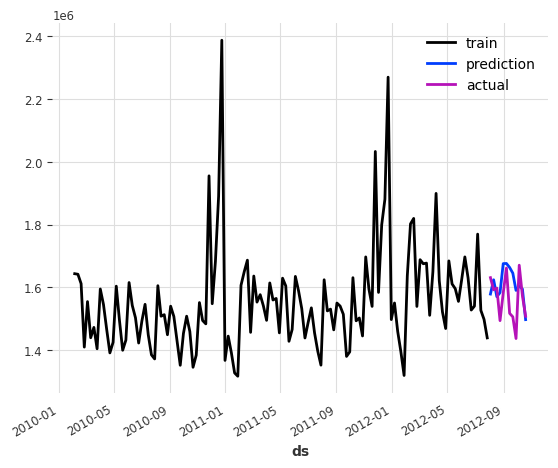

In [40]:
plotit()

In [13]:
n = 12
chunk_length = n
model = LightGBMModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 5)>
array([[[1593198.12521188, 2344904.86324741, 1577184.70005849,
         1747180.04800128, 1641308.76255625]],

       [[1554146.47535749, 1444187.59488855, 1780995.06652859,
         1536345.94594489, 1737020.85733302]],

       [[1778118.17449163, 1513492.90392872, 1516363.89558092,
         1501901.23812329, 1582293.49921   ]],

       [[1716320.80748962, 1397089.18151436, 1519889.74299773,
         1466057.59845214, 1541493.25515242]],

       [[1624164.34062585, 1587152.75201909, 1685782.31749414,
         1760546.2017698 , 1555450.99388072]],

       [[1768528.63041873, 1687972.6971626 , 1645196.19482581,
         1758163.3991611 , 1704940.31257109]],

       [[1764861.95816745, 1583243.00619796, 1573809.77490634,
         1660755.84761708, 1716616.75029181]],

       [[1483263.7780566 , 1575009.04049304, 1476764.77752111,
         1552728.9658958 , 1606150.09494595]],

       [[1595362.96613499, 1750983.02808351, 1517653.93496485,
         1562253.85575973, 1473337.58234805]],

       [[1791142.82909547, 1550889.43126414, 1452388.20111243,
         1535259.48038041, 1382434.84892679]],

       [[1520217.85538266, 1597615.38786403, 1559771.33435335,
         1557049.13833257, 1709420.92279977]],

       [[1485463.67338832, 1584091.54349767, 1493234.70203815,
         1474964.3057936 , 1459750.03276383]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

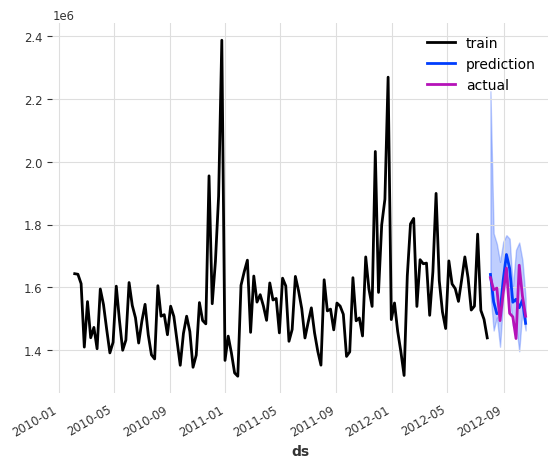

In [14]:
def plotQuantile():
    import matplotlib.pyplot as plt
    target.plot(label = 'train')
    pred.plot(label = 'prediction')
    test['Weekly_Sales'][:n].plot(label = 'actual')
plotQuantile()

In [15]:

n = 12
chunk_length = n
model = XGBModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 1)>
array([[[1546996.4]],

       [[1653806. ]],

       [[1601980.8]],

       [[1677738.8]],

       [[1711640.6]],

       [[1682701.2]],

       [[1880154.4]],

       [[1860980.4]],

       [[2022899.8]],

       [[1649062.8]],

       [[1536916.8]],

       [[1450807.8]]], dtype=float32)
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

Mean Absolute Error: 158526.35583333333
Mean Absolute Percentage Error 10.553014098158657


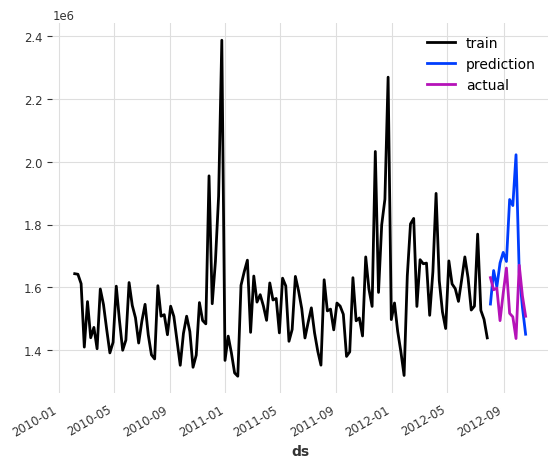

In [16]:
plotit()

In [17]:
# XGB
n = 12
chunk_length = n
model = XGBModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 5)>
array([[[1411327.31621186, 1521769.9139181 , 1654241.3131826 ,
         1526806.23658406, 1655441.00294302]],

       [[1614852.38479174, 1652978.84174624, 1584100.73079718,
         1629053.5603328 , 1516865.01304331]],

       [[1487781.3773196 , 2033435.        , 1508965.01075209,
         1561138.26375285, 1613030.24442357]],

       [[1476303.64138679, 1638287.24573904, 1536214.64398023,
         1639757.11527898, 1341221.5       ]],

       [[1699655.21514865, 1716919.6928741 , 1721551.92531879,
         1711557.52207953, 1699864.45094911]],

       [[1610707.93084613, 1500840.91760889, 1612348.11092423,
         1648860.93621363, 1490957.88644656]],

       [[1643888.08318466, 1751809.05169078, 1696132.85830033,
         1555458.28976543, 1439955.28690822]],

       [[1690649.44523534, 1653795.30115988, 1678933.5529745 ,
         1507572.45556945, 2033320.75      ]],

       [[1856946.75724432, 1452663.34877219, 1530108.48650138,
         1462264.02518228, 1345453.875     ]],

       [[1508689.91105352, 1408334.47916999, 1697423.23195349,
         1614330.82937373, 1696757.54802667]],

       [[1479234.61571319, 1384756.25206718, 1501014.94912558,
         1576704.27679261, 1613559.49778652]],

       [[1511955.64833543, 1485360.21932653, 1472728.45919013,
         1454149.10132383, 1460131.70871738]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

In [18]:

n = 12
chunk_length = n
model = CatBoostModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5],
    output_chunk_length=12,
    verbose=-1
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 1)>
array([[[1623710.09296099]],

       [[1618556.92612083]],

       [[1638724.84930259]],

       [[1688493.45449343]],

       [[1687484.56592307]],

       [[1726272.91210104]],

       [[1662904.12539692]],

       [[1720962.0088489 ]],

       [[1685520.28526041]],

       [[1690552.02955378]],

       [[1585253.56346481]],

       [[1511930.6252472 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

In [ ]:
plotit()

In [19]:
n = 12
chunk_length = n
model = CatBoostModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    output_chunk_length=chunk_length,
    likelihood = 'quantile', # Can be set to quantile or poisson.
    # If set to quantile, the sklearn.linear_model.QuantileRegressor is used.
    # Similarly, if set to poisson, the sklearn.linear_model.PoissonRegressor is used.
    quantiles=[0.01, 0.05, 0.50, 0.95,0.99]
)
model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(n, num_samples=5)
pred

<TimeSeries (DataArray) (ds: 12, component: 1, sample: 5)>
array([[[1592732.22815538, 1610862.90014763, 1564944.64576784,
         1636322.23873287, 1617056.35329611]],

       [[1593931.98695028, 1625135.06803163, 1546737.40638211,
         1717298.36038033, 1565920.53372411]],

       [[1670682.21599428, 1622554.05877772, 1610341.45729839,
         1584881.33122991, 1666978.28873673]],

       [[1598859.43332472, 1598142.44015562, 1583434.83352457,
         1701510.73068196, 1633407.63058971]],

       [[1665053.88412187, 1622663.58043123, 1664225.45225967,
         1658535.97208511, 1661541.41679665]],

       [[1601756.66819496, 1725992.4242114 , 1641106.65146951,
         1622083.05197354, 1741052.22523052]],

       [[1646029.99814011, 1641562.61609034, 1634828.32885826,
         1644719.8342442 , 1652425.37831757]],

       [[1708629.07265904, 1579172.78574072, 1632728.17432108,
         1704989.68887905, 1643263.23278823]],

       [[1722827.4080033 , 1602057.1555535 , 1728652.24480092,
         1604529.00112856, 1586257.19880081]],

       [[1656304.01809952, 1614565.47434371, 1625487.2956637 ,
         1638926.07552778, 1662095.00337921]],

       [[1572320.97679728, 1556873.9530341 , 1586659.4546416 ,
         1589193.51746948, 1561927.51710415]],

       [[1608238.83929982, 1506377.38764225, 1519134.88816973,
         1624266.13935948, 1619729.50394896]]])
Coordinates:
  * ds         (ds) datetime64[ns] 2012-08-03 2012-08-10 ... 2012-10-19
  * component  (component) object 'Weekly_Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  Store\ncomponent               \nW...
    hierarchy:          None

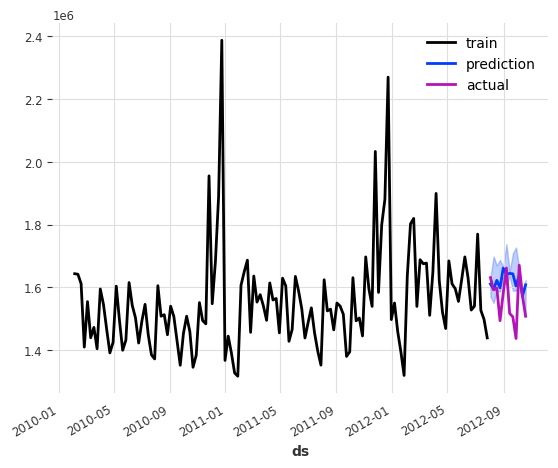

In [20]:
plotQuantile()

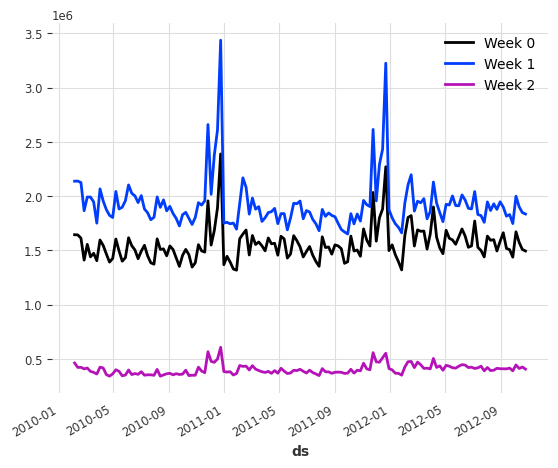

In [58]:
for i in range(3):
    darts_group_df[i]['Weekly_Sales'].plot(label=f"Week {i}")

In [59]:
#Data viz
import plotly.graph_objs as go
import plotly.express as px

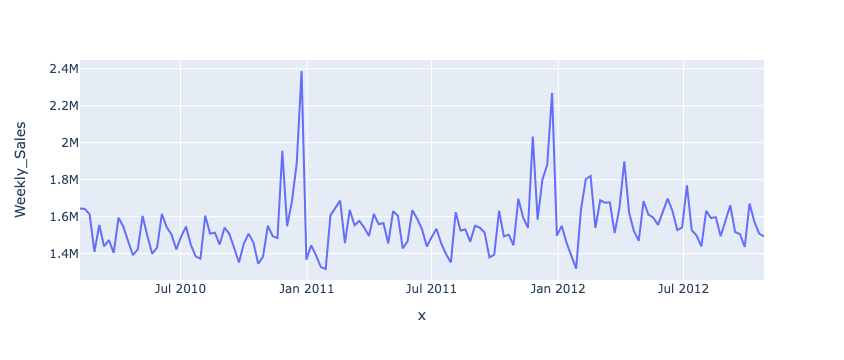

In [75]:
#declare figure
df=darts_group_df[0].pd_dataframe()
fig = go.Figure()

px.line(df, x=list(df.index), y="Weekly_Sales")


Note
===

Claude App
---
By scraping the following pages to study the power policy for every country:

1. how to extract total population table to csv in https://en.wikipedia.org/wiki/List_of_countries_by_electricity_production
2. extract population table to csv from https://www.worldometers.info/world-population/population-by-country/

Propmts
---
1. Avail the link a address and ask it to scrape the table (first table)

- Outputs: one failed (the first one) and one worked
- corectness: it can't correct the error; directly debug the content: error causeed by 'wrong' class.
  ```table = soup.find("table", {"class": "wikitable sortable sticky-header-multi static-row-numbers sort-under col1left"})```


In [ ]:
!pip install BeautifulSoup

In [102]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_countries_by_electricity_production"

# Fetch the web page content
response = requests.get(url)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

# Find the "Total Population" table
table = soup.find("table", {"class": "wikitable sortable sticky-header-multi static-row-numbers sort-under col1left"})

# Extract the table data into a Pandas DataFrame
df = pd.read_html(str(table))[0]

# Save the DataFrame as a CSV file
df.iloc[1:].to_csv("total_population_table.csv", index=False)
print("CSV file saved: total_population_table.csv")

CSV file saved: total_population_table.csv


In [85]:
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_countries_by_electricity_production"

# Fetch the web page content
response = requests.get(url)
html_content = response.content


In [ ]:
# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

# Find the "Total Population" table
soup.find("table", {"class": "wikitable sortable sticky-header-multi static-row-numbers sort-under col1left"})

In [88]:
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
#indiatable

In [83]:
response

<Response [200]>

In [82]:
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})

In [92]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# URL of the webpage
url = "https://www.worldometers.info/world-population/population-by-country/"

# Fetch the webpage content
response = requests.get(url)
html_content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

# Find the "Population" table
table = soup.find("table", {"id": "example2"})

# Extract the table headers
headers = [th.text.strip() for th in table.find_all("th")]

# Extract the table data
data = []
for row in table.find_all("tr")[1:]:  # Skip the header row
    row_data = [td.text.strip() for td in row.find_all("td")]
    data.append(row_data)

# Create a Pandas DataFrame from the extracted data
df1 = pd.DataFrame(data, columns=headers)

# Save the DataFrame as a CSV file
df1.to_csv("population_table.csv", index=False)
print("CSV file saved: population_table.csv")

CSV file saved: population_table.csv


In [91]:
df.head()

Location Total (TWh) Generation (Terawatt-hours)                  \
        Location Total (TWh)                        Coal     Gas   Hydro   
0          World     28003.0                     10095.0  6399.0  4246.0   
1          China      8534.0                      5329.0   287.0  1300.0   
2  United States      4154.0                       898.0  1579.0   246.0   
3          India      1715.0                      1274.0    60.0   160.0   
4         Russia      1110.0                       169.0   485.0   215.0   

                                               
  Nuclear    Wind   Solar   Oil*   Bio.  Geo.  
0    2750  1848.0  1047.0  868.0  657.0  93.0  
1     408   656.0   327.0   62.0  166.0   0.0  
2     780   378.0   164.0   35.0   54.0  18.0  
3      44    68.0    68.0    3.0   37.0   0.0  
4     222     4.0     2.0   12.0    0.8   0.4

Prompt 
---
Ask it to calculate the `Power comsumption/Person`; failed

- Population number is seperated by comma symbol, `,`, every three digits: wrong, it is not numeric!
- 

In [113]:
df_wiki = pd.read_csv("total_population_table.csv")
df_wiki=df_wiki.iloc[1:]

In [114]:
df_worldometers = pd.read_csv("population_table.csv")
df_worldometers.head(2)

# Country (or dependency) Population (2023) Yearly Change  Net Change  \
0  1                   India     1,428,627,663        0.81 %  11,454,490   
1  2                   China     1,425,671,352       -0.02 %    -215,985   

  Density (P/Km²) Land Area (Km²) Migrants (net)  Fert. Rate  Med. Age  \
0             481       2,973,190       -486,136         2.0      28.0   
1             152       9,388,211       -310,220         1.2      39.0   

  Urban Pop % World Share  
0        36 %     17.76 %  
1        65 %     17.72 %

In [115]:
merged_df = pd.merge(df_wiki, df_worldometers, left_on="Location", right_on="Country (or dependency)", how="left")


In [116]:
df2=merged_df[['Location','Total (TWh)','Population (2023)']].copy()

In [117]:
# convert Population into nueric: 
df2['Population (2023)']=df2['Population (2023)'].replace({',':''}, regex = True)

In [118]:
##convert Population into numeric:
df2.dropna(inplace=True)
df2['Population (2023)']=df2['Population (2023)'].astype(str).astype(int)

In [119]:
df2['Total (TWh)']=df2['Total (TWh)'].astype(str).astype(float)

In [120]:
df2['Total (TWh)/Population']=df2['Total (TWh)']/df2['Population (2023)']

In [ ]:
!pip install plotly

In [121]:
import plotly.graph_objs as go
import plotly.express as px

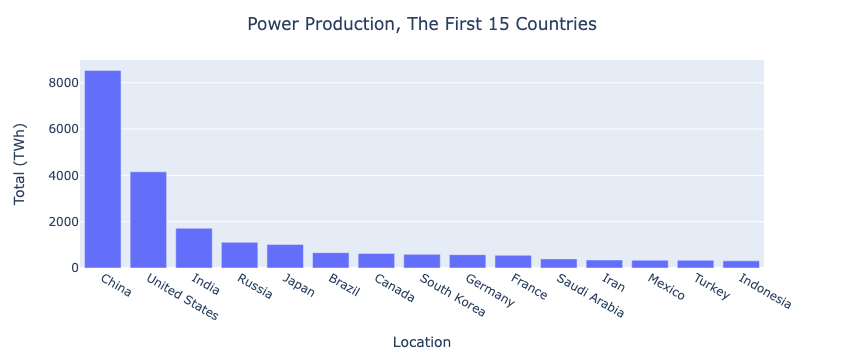

In [129]:
#fig=px.line(df2[:15], x='Location', y="Total (TWh)", markers=True)
fig=px.bar(df2[:15], x='Location', y="Total (TWh)")

fig.update_layout(title_text='Power Production, The First 15 Countries', title_x=0.5)

In [131]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, 0 to 205
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Location                193 non-null    object 
 1   Total (TWh)             193 non-null    float64
 2   Population (2023)       193 non-null    int64  
 3   Total (TWh)/Population  193 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 7.5+ KB


In [133]:
(df2.sort_values(by='Total (TWh)/Population'))[['Location','Total (TWh)/Population']].tail(15).T

125          7         106       144       16   \
Location                  Brunei  South Korea    Bhutan      Guam    Taiwan   
Total (TWh)/Population  0.000011     0.000011  0.000011  0.000012  0.000012   

                                  1         44                    30   \
Location                United States   Finland  United Arab Emirates   
Total (TWh)/Population       0.000012  0.000013              0.000016   

                             6         26        45        54        68   \
Location                  Canada    Sweden    Kuwait     Qatar   Bahrain   
Total (TWh)/Population  0.000016  0.000016  0.000016  0.000018  0.000022   

                             27        82   
Location                  Norway   Iceland  
Total (TWh)/Population  0.000029  0.000051

In [134]:
df3=df2.sort_values(by='Total (TWh)/Population').reset_index()

In [135]:
df3.tail(15)

index              Location  Total (TWh)  Population (2023)  \
178    125                Brunei          5.0             452524   
179      7           South Korea        589.0           51784059   
180    106                Bhutan          9.0             787424   
181    144                  Guam          2.0             172952   
182     16                Taiwan        288.0           23923276   
183      1         United States       4154.0          339996563   
184     44               Finland         72.0            5545475   
185     30  United Arab Emirates        149.0            9516871   
186      6                Canada        626.0           38781291   
187     26                Sweden        172.0           10612086   
188     45                Kuwait         71.0            4310108   
189     54                 Qatar         48.0            2716391   
190     68               Bahrain         32.0            1485509   
191     27                Norway        157.0            5474360   
192     82               Iceland         19.0             375318   

     Total (TWh)/Population  
178                0.000011  
179                0.000011  
180                0.000011  
181                0.000012  
182                0.000012  
183                0.000012  
184                0.000013  
185                0.000016  
186                0.000016  
187                0.000016  
188                0.000016  
189                0.000018  
190                0.000022  
191                0.000029  
192                0.000051

In [136]:
df3[df3['Location']=='India']

index Location  Total (TWh)  Population (2023)  Total (TWh)/Population
69      2    India       1715.0         1428627663                0.000001

In [137]:
df3[df3['Location']=='China']

index Location  Total (TWh)  Population (2023)  Total (TWh)/Population
153      0    China       8534.0         1425671352                0.000006

In [138]:
df3[df3['Location']=='France']

index Location  Total (TWh)  Population (2023)  Total (TWh)/Population
171      9   France        550.0           64756584                0.000008

In [139]:
Countries=list(df3['Location'][-15:])
Countries.append('China')
Countries.append('India')
Countries.append('France')

len(Countries)

18

In [140]:
China=df3[df3.Location=='China']['Total (TWh)/Population'].values
India=df3[df3.Location=='India']['Total (TWh)/Population'].values
France=df3[df3.Location=='France']['Total (TWh)/Population'].values

In [141]:
China_all=df3[df3.Location=='China']['Total (TWh)'].values
India_all=df3[df3.Location=='India']['Total (TWh)'].values
France_all=df3[df3.Location=='France']['Total (TWh)'].values

In [142]:
Total= list(df3['Total (TWh)'][-15:])
Total.append(China_all[0])
Total.append(India_all[0])
Total.append(France_all[0])

Total=[np.round(i/120,2) for i in Total]

In [143]:
Comsumption=list(df3['Total (TWh)/Population'][-15:])
Comsumption.append(China[0])
Comsumption.append(India[0])
Comsumption.append(France[0])

In [ ]:
!pip install pyecharts

In [109]:
from pyecharts.charts import Bar
from pyecharts import options as opts

In [145]:
bar = Bar()
bar.add_xaxis(Countries)
bar.add_yaxis("Total (TWh)/Population", Comsumption)
bar.set_global_opts(title_opts=opts.TitleOpts(title="World ower Comsumption", subtitle="The First 15 and Others"))
bar.set_global_opts(xaxis_opts=opts.AxisOpts(
									name=Countries,
									axislabel_opts=opts.LabelOpts(rotate=45)
									),)
bar.set_series_opts(label_opts=opts.LabelOpts(is_show=False),)
# we can also define file 
bar.render("pyechart1.html")

'/Users/chu-chinghuang/Documents/2023/2023-2-Python/pyechart1.html'

In [164]:
bar =( Bar()
       .add_xaxis(Countries)
       .add_yaxis("Total (TWh)/Population", Comsumption)
       .set_global_opts(xaxis_opts=opts.AxisOpts(
									name=Countries,
									axislabel_opts=opts.LabelOpts(rotate=45)
									),)
       .set_series_opts(label_opts=opts.LabelOpts(is_show=False),)
       .set_global_opts(title_opts=opts.TitleOpts(title="World ower Comsumption", subtitle="The First 15 and Others"))     
     )
# we can also define file 
bar.render("pyechart1.html")

'/Users/chu-chinghuang/Documents/2023/2023-2-Python/pyechart1.html'

In [165]:
from IPython.display import HTML
HTML("pyechart1.html")

In [156]:
Comsumption1=[np.round(i*1e6,2) for i in Comsumption]

In [162]:
bar = Bar()
bar.add_xaxis(Countries)
bar.add_yaxis("Total (TWh)/Population", Comsumption1)
bar.add_yaxis("Total (TWh)", Total)

bar.set_global_opts(xaxis_opts=opts.AxisOpts(
									name=Countries,
									axislabel_opts=opts.LabelOpts(rotate=45)
									),)
bar.set_series_opts(label_opts=opts.LabelOpts(is_show=False),)
bar.set_global_opts(title_opts=opts.TitleOpts(title="World ower Comsumption", subtitle="The First 15 and Others"))

bar.render("pyechart2.html")

'/Users/chu-chinghuang/Documents/2023/2023-2-Python/pyechart2.html'

In [166]:
from IPython.display import HTML
HTML("pyechart2.html")